# Simplify SPMe+SEI Model 

The main purpose of this section is to reformulate the SPMe+RF model from. 

Assumptions:

<ol>
    <li> The diffusivity parameter of lithium ion in the negative particle is constant.</li>
    <li> The concentration of lithium ions in the electrolyte is constant.</li>
    <li> The conductivity and transport efficiency of the electrolyte are also constant </li>
    </ol>

$$  
\begin{equation}
\frac{d \bar{\hat{c}}_{\mathrm{n0}}}{d\hat{t}}=\frac{-3}{\alpha_n }\hat{J}_\mathrm{n}^\mathrm{total}.
\end{equation}
$$

$$
 \frac{\partial \varepsilon_\mathrm{n}}{\partial t}= \frac{M_\mathrm{SR}}{n_\mathrm{SR} \rho_\mathrm{SR} F} \bar{J}_\mathrm{SR},
 $$
$$
  L_\mathrm{f, n}=L_\mathrm{f,n,init}-\frac{1}{a_\mathrm{n}}(\varepsilon_\mathrm{n}-\varepsilon_\mathrm{n, init}) 
 $$
 
$$
    J_\mathrm{n}^{\mathrm{total}}=\frac{i_\mathrm{app}}{L_\mathrm{n}}-\bar{J}_\mathrm{SR}, 
$$

$$
    \bar{J}_\mathrm{SR}=\frac{1}{L_\mathrm{n}} \int_0^{L_\mathrm{n}} J_\mathrm{SR} d\scriptstyle{\mathcal{X}},
$$

$$
    J_{\mathrm{SR}}=-a_\mathrm{n} j_\mathrm{SR} \mathrm{exp}\left(-\alpha_\mathrm{SR}\frac{F}{RT} \left(\phi_\mathrm{n}-\phi_\mathrm{e}-U_\mathrm{SR}-\frac{i_\mathrm{app}L_\mathrm{f, n}}{a_\mathrm{n} \sigma_\mathrm{f, n} L_\mathrm{n}} \right ) \right ).
$$

\begin{equation}
\begin{aligned}
&\phi_\mathrm{n}=U_\mathrm{n}(\bar{c}_\mathrm{n}|_{r=R_{n}}) \\
  &\phi_e=- \frac{i_\mathrm{app} }{2 \sigma_\mathrm{e} {\scriptstyle\mathcal{B}} L_n}\scriptstyle\mathcal{X}^2
  \end{aligned}
\end{equation}

So, Basically we are trying two solve DAEs with (1,2 3, 6, 7) for the variables $\bar{c}$, $\varepsilon$, $L_\mathrm{f, n}$,  $\phi_e$ and $\phi_n$ with approperiate initial conditions. For Simiplicity (now) we only conider first terms for $\phi_e$ and $\phi_n$.

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
# import scipy.sparse as sparse
# pybamm.__version__

In [2]:
cn_av = pybamm.Variable("Concentration [mol.m-3]")
phi_n = pybamm.Variable("Negative electrode potential [V]", domain="negative electrode")
phi_e_n = pybamm.Variable("Negative electrolyte potential [V]", domain="negative electrode")
E_n = pybamm.Variable("Negative electrode porosity", domain="negative electrode")
L_SEI = pybamm.Variable("Thickness of SEI [m]", domain="negative electrode")

x_n = pybamm.SpatialVariable("x_n", domain=["negative electrode"], coord_sys="cartesian")

In [3]:
# dimensional pybamm.Parameter(eters)
R_n = pybamm.Parameter('Negative particle radius [m]')
T = pybamm.Parameter('Initial temperature [K]')
R = pybamm.Parameter('Ideal gas constant [J.K-1.mol-1]')
F = pybamm.Parameter("Faraday constant [C.mol-1]")
cn0 = pybamm.Parameter('Initial concentration in negative electrode [mol.m-3]')
c_e = pybamm.Parameter('Initial concentration in electrolyte [mol.m-3]')
L_n = pybamm.Parameter("Negative electrode thickness [m]")
I_app = pybamm.Parameter("Applied current [A]")
j_SEI_0 =  pybamm.Parameter('Initial SEI reaction exchange current density [A.m-2]')
an = pybamm.Parameter('Particle surface area to volume ratio [m-1]')
U_SEI= pybamm.Parameter('SEI open-circuit potential [V]')
s_SEI = pybamm.Parameter("SEI conductivity [S.m-1]")
L_SEI_0 = pybamm.Parameter("Initial SEI thickness [m]")
alpha_SEI = pybamm.Parameter("alpha_SEI [-]")
sigma_e = pybamm.Parameter('Electrolyte conductivity [S.m-1]')
B =  pybamm.Parameter('Negative electrode Bruggeman coefficient (electrolyte)')
E_init=pybamm.Parameter('Initial negative electrode porosity')
M_SEI=pybamm.Parameter("Molar weight of SEI material [kg.mol-1]")
rho_SEI=pybamm.Parameter( "Density of SEI material [kg.m-3]")
n_SEI=pybamm.Parameter( "electrone number [-]")
c_n_max = pybamm.Parameter("Maximum concentration in negative electrode [mol.m-3]")

# Un = pybamm.ParameterValues("Chen2020")['Negative electrode OCP [V]']
# Un=pybamm.FunctionParameter("Negative electrode OCP [V]", {"Concentration [mol.m-3]": cn0})
def Un(x):
  return pybamm.FunctionParameter(
    "Negative electrode OCP [V]",
    {"Negative particle stoichiometry": x},
  )



In [4]:
from pybamm import tanh
from pybamm import exp
def OCP_n(cc):
    stretch = 1.00
    # sto = stretch * cc / c_n_max
    sto=cc
    u_eq = (
        1.9793 * exp(-39.3631 * sto)
        + 0.2482
        - 0.0909 * tanh(29.8538 * (sto - 0.1234))
        - 0.04478 * tanh(14.9159 * (sto - 0.2769))
        - 0.0205 * tanh(30.4444 * (sto - 0.6103))
    )
    return u_eq




In [5]:
param = pybamm.ParameterValues(
    {'Negative particle radius [m]': 5.86e-06,  # from Chen2020
     'Initial temperature [K]': 298.15,  # from Chen2020
     'Ideal gas constant [J.K-1.mol-1]': 8.314462618,   # from Chen2020
     "Faraday constant [C.mol-1]": 96485.33212,  # from Chen2020
     'Initial concentration in negative electrode [mol.m-3]': 870,
     'Initial concentration in electrolyte [mol.m-3]': 1000,
     "Negative electrode thickness [m]": 8.52e-05, # from Chen2020
     "Applied current [A]": -1.95,
     'Initial SEI reaction exchange current density [A.m-2]': 1.5e-07,   # from Chen2020
     'Particle surface area to volume ratio [m-1]': 3.84e5, #From Ferran AMM 2023
     'SEI open-circuit potential [V]':  0.4, # from Chen2020
     "SEI conductivity [S.m-1]": 5e-6,   #From Ferran AMM 2023
     "Initial SEI thickness [m]": 1e-12,
     "alpha_SEI [-]": 0.22,
     'Electrolyte conductivity [S.m-1]': 0.9486,
      'Negative electrode Bruggeman coefficient (electrolyte)': 1.5,  # from Chen2020
     'Initial negative electrode porosity': 0.25, # from Chen2020
     "Molar weight of SEI material [kg.mol-1]": 0.162, #From Ferran AMM 2023
     "Density of SEI material [kg.m-3]": 1690,  #From Ferran AMM 2023
    "electrone number [-]": 2, # from Chen2020
    "Maximum concentration in negative electrode [mol.m-3]": 33133.0,    # from Chen2020
    "Negative electrode OCP [V]": OCP_n,
    }
)

In [6]:
model = pybamm.lithium_ion.BaseModel()

In [7]:
model.variables = {
    "Concentration [mol.m-3]": cn_av,
    "Negative electrode potential [V]": phi_n,
    "Negative electrolyte potential [V]":  phi_e_n,
    "Negative electrode porosity": E_n, 
    "Thickness of SEI [m]": L_SEI,
    "Voltage [V]": pybamm.boundary_value(-phi_n, "left")
}

In [8]:

model.algebraic = {
  phi_n: phi_n -  Un(cn_av/c_n_max),
  phi_e_n: phi_e_n - I_app/(2.0*sigma_e*B*L_n)*x_n*x_n,
  L_SEI: L_SEI - L_SEI_0-1/an*(E_n-E_init),
  }

In [9]:

J_SR =  -an * j_SEI_0 * pybamm.exp(-alpha_SEI*F/(R*T) * (phi_n - phi_e_n - U_SEI- (I_app*L_SEI/(L_n*an*s_SEI))))
J_SR_AV =  pybamm.x_average(J_SR)

In [10]:
dcndt = -3/(an*R_n*F)*(I_app/L_n - J_SR_AV)
dEndt=M_SEI/(n_SEI*rho_SEI*F)*J_SR_AV

In [11]:
model.rhs = {cn_av: dcndt, E_n: dEndt} 

In [12]:

model.initial_conditions = {
    phi_n: Un(cn0/c_n_max),
    phi_e_n: 0,
    L_SEI: L_SEI_0,
    cn_av: cn0,
    E_n: E_init,
}

In [13]:
geometry = {
    "negative electrode": {x_n: {"min": 0, "max": L_n}},
}

In [14]:
param.process_model(model)
param.process_geometry(geometry)

In [15]:
submesh_types = {
    "negative electrode": pybamm.Uniform1DSubMesh,
   # "negative particle": pybamm.Uniform1DSubMesh,
}
# var_pts = {x_n: 20, r: 30}
var_pts = {x_n: 10}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {
    "negative electrode": pybamm.FiniteVolume(),
}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

In [16]:
cycle_number =2
exp = pybamm.Experiment(
    [("Charge at C/20 until 4.2 V",
       "Rest for 20 hours",
     "Discharge at C/20 until 0 V",
     "Rest for 20 hours")] *cycle_number
#      +[("Charge at 0.3C  until 4.2 V", 
#       "Rest for 2 hours", 
#       "Discharge at 0.7C until 2.5 V", 
#        "Rest for 2 hours")]* cycle_number
)




# s = pybamm.step.string
# exp = pybamm.Experiment(
#     [
#         (s("Charge at C/20 until 4.2 V", period="10 minutes"),
#         s("Rest for 1 hour", period="3 minutes")),
#     ]
# )

In [17]:
# solver = pybamm.CasadiSolver()
solver = pybamm.IDAKLUSolver()
t = np.linspace(0, 50000, 100)
sim=pybamm.Simulation(model, parameter_values=param, solver=solver)
    # sim = pybamm.Simulation(models[index],  experiment=exp, var_pts=var_pts,   solver=solver)

solution =sim.solve(t)


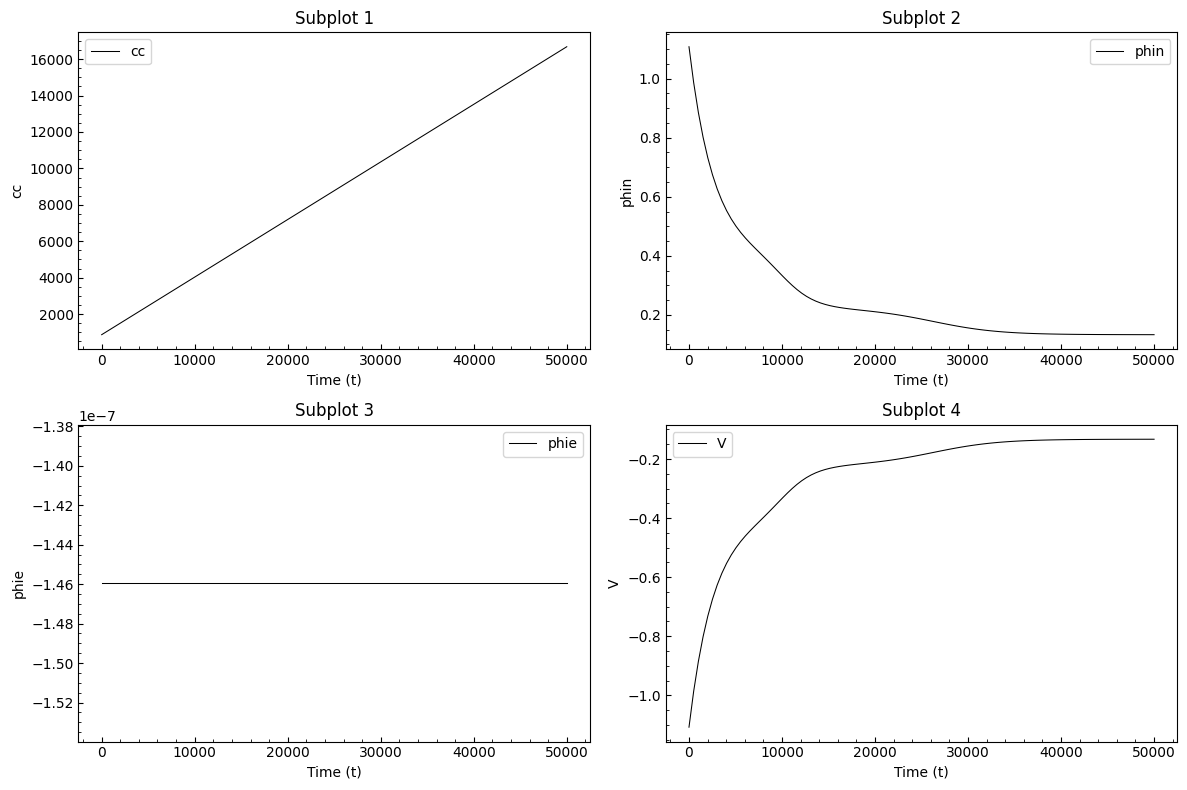

In [18]:
sol = []
tt = solution.t
sol.append(solution["Concentration [mol.m-3]"].entries)
sol.append(solution["Negative electrode potential [V]"].entries[0])
sol.append(solution["Negative electrolyte potential [V]"].entries[0])
sol.append(solution["Voltage [V]"].entries)
Label = ["cc", "phin", "phie", "V"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i in range(4):  # Loop through the data to plot in subplots
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    ax.plot(tt, 
            sol[i],
            label=Label[i],
            linestyle="-",
            color="black",
            linewidth=0.75)

    ax.set_title("Subplot " + str(i+1))
    ax.set_xlabel("Time (t)")
    ax.set_ylabel(Label[i])
    ax.legend()
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in')

    # Add minor ticks

# ax.grid(which='minor', linestyle='--', linewidth=0.5)
# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()


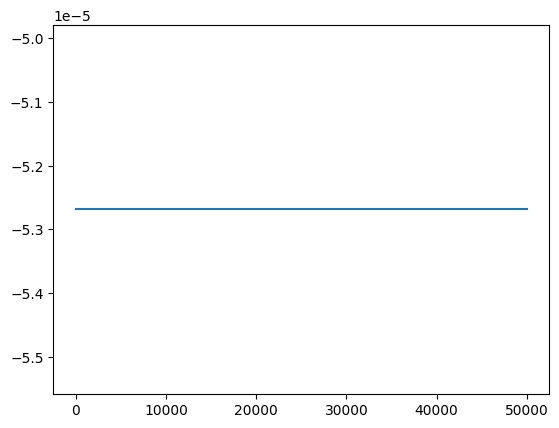

In [19]:
# # cc=solution["cn"]
# # ee=solution["E_n"]
# # plt.plot(t,cc)
tt=solution.t
cc=solution["Concentration [mol.m-3]"].entries
phin=solution["Negative electrode potential [V]"].entries 
phie= solution["Negative electrolyte potential [V]"].entries
v= solution["Voltage [V]"].entries

# En=solution["Concentration [mol.m-3]"].entries
# # L_SEI=solution["Thickness of SEI [m]"].entries
# # L_SEI: L_SEI_0-1/an*(En-E_init)  
# plt.plot(tt,cc)
# v=phin - phie


plt.plot(tt,phie[9,:])
# # plt.plot(tt,L_SEI[0,:])

In [ ]:
# Test git

In [20]:
#This comment for test

<function print>